### Resources

**Load Images**
- https://huggingface.co/docs/datasets/use_with_pytorch
- https://huggingface.co/docs/datasets/v2.14.5/en/image_load

**Process images:**
- image processing: https://huggingface.co/docs/datasets/image_process#map
- transforms methods: https://pytorch.org/vision/stable/transforms.html#transforms
- HF general processing: https://huggingface.co/docs/datasets/process
- transforms v2 reference: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

**Test/Train split**
- use this: https://huggingface.co/docs/datasets/v2.15.0/en/package_reference/main_classes#datasets.Dataset.train_test_split

**PyTorch Classification Tutorial**
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

**Building a Model Basics**
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

import shutil
import pathlib
import PIL
from PIL import Image

import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Matplotlib created a temporary cache directory at /tmp/matplotlib-3xl0pfh0 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# check for GPU and create the device object
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [3]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)

# import data (specifying GPU on 
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format('torch', device=device)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# define our labels
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [5]:
# create a pandas copy for easier PIL exploration
df_clone = dataset.to_pandas()
df_clone = df_clone.assign(
    desc = df_clone.label.map(label_values),
    image = df_clone.image.apply(lambda x: x['path']))
df_clone.head()

,image,label,desc
0,/workspace/hf_cache/downloads/c1788b27609c6ad9...,0,harp
1,/workspace/hf_cache/downloads/8f8cdb21c6698ee6...,0,harp
2,/workspace/hf_cache/downloads/41f7f4b3f28c4ede...,0,harp
3,/workspace/hf_cache/downloads/4bce77de0a7870be...,0,harp
4,/workspace/hf_cache/downloads/e5502c68bcbbc862...,0,harp


0 : harp


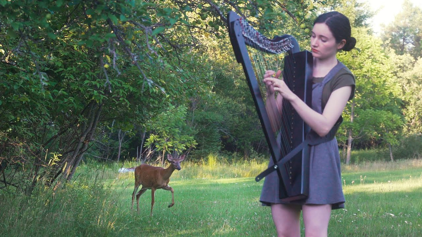

3 : acoustic guitar


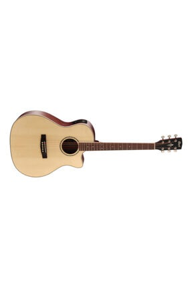

6 : kemence


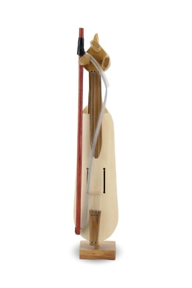

9 : yayli tambur


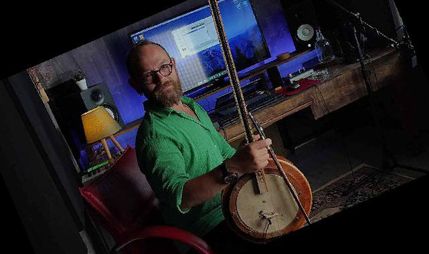

In [6]:
# view some images and labels
def img_check(i, scale):
    print(df_clone.label[i],':',df_clone.desc[i])
    img = PIL.Image.open(df_clone.image[i])
    img = img.resize((int(img.size[0]/(100/scale)), int(img.size[1]/(100/scale))))
    img.show()

img_check(0, 33)
img_check(333, 67)
img_check(666, 67)
img_check(999, 67)

In [7]:
# isolate RGB images for pre processing
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [8]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=10)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


torch.Size([3, 720, 1280])

In [9]:
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

11

In [10]:
# some of the images are greyscale, so we convert to RGB as well
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])
torch.Size([3, 849, 900])


In [11]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

In [12]:
# confirming 0-255 scaling and int dtype of image tensors
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print("Sample values:", sample_image.flatten()[:10])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Tensor dtype: torch.int64
Sample values: tensor([40, 39, 41, 41, 41, 44, 48, 53, 54, 52], device='cuda:0')
Max value: 255
Min value: 0


In [13]:
# compose transformation function
def scale_tensor(tensor):
    return tensor.float() / 255

basic_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
    v2.RandomHorizontalFlip(p=0.5),
    scale_tensor, # converts to [0, 1] float dtype
    v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization for resnet
])

# application function for transforms
def apply_transform(example):
    # Apply the transformation to the 'image' field
    example['image'] = [basic_transform(img) for img in example['image']]
    return example

# apply transforms
dataset = dataset.map(apply_transform, batched=True, batch_size=100)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
# quick check on the transform
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print('Sample values:', sample_image.flatten()[0:10])
print('Max value:', sample_image.max().item())
print('Min value:', sample_image.min().item())

Tensor dtype: torch.float32
Sample values: tensor([-0.9020, -0.9020, -0.6794, -0.7650, -0.9363, -0.8678, -0.4568, -0.2513,
        -0.2684,  0.0912], device='cuda:0')
Max value: 2.517995834350586
Min value: -1.7925336360931396


### Examine Dataset/Model Compatibility Before Training

In [15]:
# are all tensors shape [3, 224, 224]?

correct_tensor_shape = 0

for i in range(len(dataset)):
    if dataset[i]['image'].shape != torch.Size([3, 224, 224]):
        print(f"Image at index {i} has incorrect shape: {image.shape}")
    else:
        correct_tensor_shape += 1

print(correct_tensor_shape)

1000


2 : electric guitar


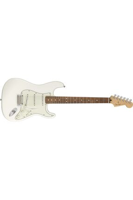

2 : electric guitar


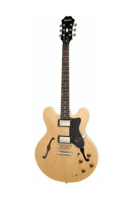

2 : electric guitar


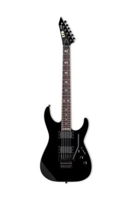

2 : electric guitar


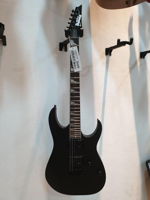

2 : electric guitar


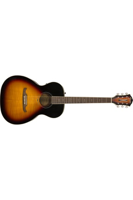

7 : mandolin


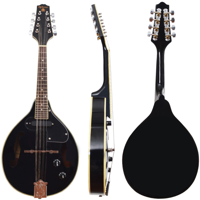

7 : mandolin


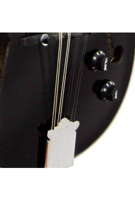

7 : mandolin


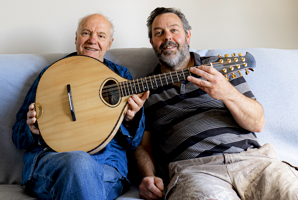

7 : mandolin


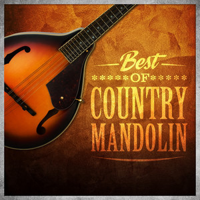

7 : mandolin


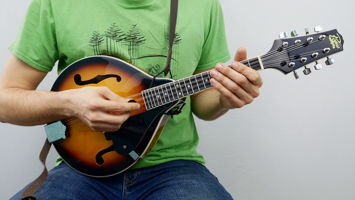

8 : oud


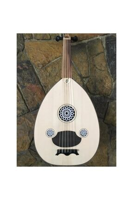

8 : oud


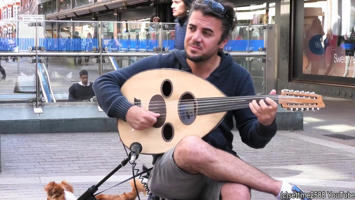

8 : oud


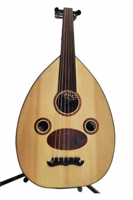

8 : oud


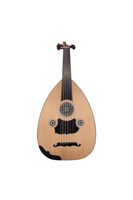

8 : oud


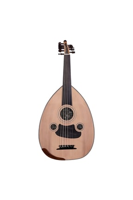

4 : kanun


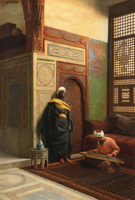

4 : kanun


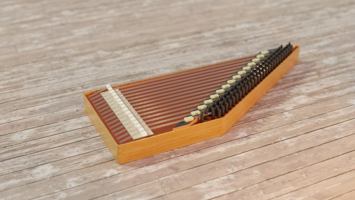

4 : kanun


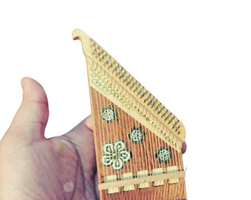

4 : kanun


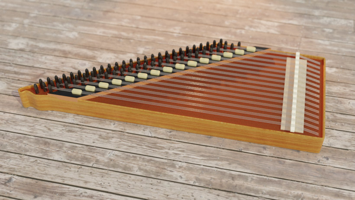

4 : kanun


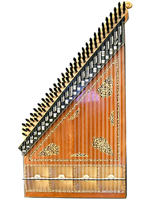

In [16]:
# are labels and images consistent?

#function to print a random x images/labels for a given instrument
def check_instrument(instrument, sample_size):    
    check = df_clone.loc[df_clone.desc == instrument].sample(sample_size).reset_index()
    for row in range(sample_size):
        image = check.image[row]
        img = PIL.Image.open(image).convert('RGB')
        img = img.resize((max(1, int(img.size[0] * 200 / img.size[1])), 200))
        print(check.label[row],':', check.desc[row])
        img.show()        

# check some images
check_instrument('electric guitar', 5)
check_instrument('mandolin', 5)
check_instrument('oud', 5)
check_instrument('kanun', 5)

### Dataloader Setup

In [17]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

In [18]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=0)

**replacing tutorial model with pre-trained [resnet 18](https://arxiv.org/abs/1512.03385)**

In [19]:
# set a cache in our Docker workspace
os.environ['TORCH_HOME'] = os.getcwd()

# import
from torchvision.models import resnet18, ResNet18_Weights

In [30]:
# load model with weights (only one option)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

Using cache found in /workspace/hub/pytorch_vision_v0.10.0


In [31]:
# modifying the final layer to suit our 10 classes
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# freeze layers that aren't final fully connected layer
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False

# back on the GPU, set to eval
model = model.eval()
model = model.to(device)

In [32]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Testing Model before Fine Tuning

In [33]:
# create iterator
dataiter = iter(testloader)

In [34]:
# iterate through the test batch (could use training images too, we have not fine tuned yet)
def testbatch():
    batch = next(dataiter)
    images = batch['image']
    labels = batch['label']

# test the model output on these images
    with torch.no_grad():
        outputs = model(images)
    actual = [label_values[lbl.item()] for lbl in labels]
    predicted = [label_values[i.item()] for i in torch.max(outputs, 1)[1]]
    print('predicted: '+', '.join(predicted))
    print('actual: '+', '.join(actual))
    print(' ')

testbatch()
testbatch()
testbatch()

predicted: harp, violin, violin, kanun
actual: kemence, violin, violin, baglama
 
predicted: violin, violin, harp, violin
actual: yayli tambur, oud, baglama, violin
 
predicted: kanun, harp, acoustic guitar, harp
actual: kemence, baglama, acoustic guitar, yayli tambur
 


In [35]:
# calculate accuracy
correct = 0
total = 0

for data in testloader:
    images = data['image']
    labels = data['label']
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'{correct} of {total} images categorized correctly: {100 * correct // total} %')

42 of 200 images categorized correctly: 21 %


In [36]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for batch in testloader:
    images = batch['image']
    labels = batch['label']
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output, 1)

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

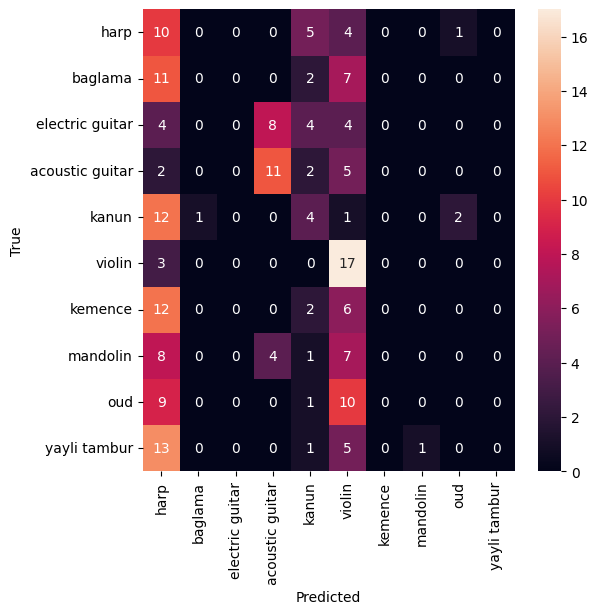

In [39]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Fine Tuning the Model

In [40]:
# Define loss function: Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # unchanged from tutorial

### Training Loop with logging for loss, accuracy, and model state

In [41]:
training_log = {'epoch': [], 'loss' : [], 'train_acc': [], 'test_acc': [], 'model_state': []}

def fine_tune(start_epoch, end_epoch, model, trainloader, testloader, optimizer, criterion, training_log):

    for epoch in range(start_epoch, end_epoch): 
    
        # set baseline for epoch
        running_loss = 0.0
        train_labels, train_pred = [], []
        model.train()

        # loop through each batch of the training dataloader
        for i, data in enumerate(trainloader, 0):
            inputs = data['image']
            labels = data['label']
        
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # catalog training results
            _, predicted = torch.max(outputs, 1)
            train_labels.append(labels.cpu())
            train_pred.append(predicted.cpu())
        
            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                training_log['loss'].append(running_loss/200) # log the epoch loss before resetting it
                running_loss = 0.0

        # training results lists into tensors and calculate training accuracy
        train_labels = torch.cat(train_labels)
        train_pred = torch.cat(train_pred)
        train_acc = (train_pred == train_labels).sum().item() / train_labels.size(0)

        # test model after each training epoch
        test_labels, test_pred = [], []
        model.eval()
    
        for i, data in enumerate(testloader, 0):
            inputs = data['image']
            labels = data['label']
            outputs = model(inputs)

            # catalog test results
            _, predicted = torch.max(outputs, 1)
            test_labels.append(labels.cpu())
            test_pred.append(predicted.cpu())

        # test results lists into tensors and calculate test accuracy
        test_labels = torch.cat(test_labels)
        test_pred = torch.cat(test_pred)    
        test_acc = (test_pred == test_labels).sum().item() / test_labels.size(0)
    
        # add epoch details to training log
        training_log['epoch'].append(epoch) # epoch number
        training_log['train_acc'].append(train_acc) # training accuracy
        training_log['test_acc'].append(test_acc) # test accuracy

        # save the model
        cwd = os.getcwd()
        filename = f'model_state_epoch_{epoch}.pth'
        path = os.path.join(cwd, filename)
        torch.save(model.state_dict(), path)
        training_log['model_state'].append(path)

In [42]:
# test one loop of the fine tuning function
fine_tune(0, 1, model, trainloader, testloader, optimizer, criterion, training_log)

In [43]:
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)
training_results.head(20)

,epoch,loss,train_acc,test_acc,model_state
0,0,1.916674,0.3375,0.665,/workspace/model_state_epoch_0.pth


In [44]:
# ready to fine tune :)
fine_tune(1, 20, model, trainloader, testloader, optimizer, criterion, training_log)

training_results = pd.DataFrame.from_dict(training_log)
training_results.head(20)

,epoch,loss,train_acc,test_acc,model_state
0,0,1.916674,0.33750,0.665,/workspace/model_state_epoch_0.pth
1,1,1.198139,0.62000,0.760,/workspace/model_state_epoch_1.pth
2,2,0.961897,0.70500,0.765,/workspace/model_state_epoch_2.pth
3,3,0.833242,0.74750,0.770,/workspace/model_state_epoch_3.pth
4,4,0.746372,0.78750,0.760,/workspace/model_state_epoch_4.pth
5,5,0.680751,0.81125,0.765,/workspace/model_state_epoch_5.pth
6,6,0.627815,0.82875,0.760,/workspace/model_state_epoch_6.pth
7,7,0.583432,0.84625,0.755,/workspace/model_state_epoch_7.pth
8,8,0.545345,0.86250,0.760,/workspace/model_state_epoch_8.pth
9,9,0.512158,0.87375,0.755,/workspace/model_state_epoch_9.pth


In [48]:
# load the model state just before (highest test accuracy, just before training acc started to overtake test acc)
model.load_state_dict(torch.load('/workspace/model_state_epoch_3.pth'))

# unfreezing the final block and fine tuning further
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

In [53]:
# testing 20 more training loops with last block unfrozen
fine_tune(20, 41, model, trainloader, testloader, optimizer, criterion, training_log)

training_results = pd.DataFrame.from_dict(training_log)

In [52]:
training_results

,epoch,loss,train_acc,test_acc,model_state
0,0,1.916674,0.33750,0.665,/workspace/model_state_epoch_0.pth
1,1,1.198139,0.62000,0.760,/workspace/model_state_epoch_1.pth
2,2,0.961897,0.70500,0.765,/workspace/model_state_epoch_2.pth
3,3,0.833242,0.74750,0.770,/workspace/model_state_epoch_3.pth
4,4,0.746372,0.78750,0.760,/workspace/model_state_epoch_4.pth
5,5,0.680751,0.81125,0.765,/workspace/model_state_epoch_5.pth
6,6,0.627815,0.82875,0.760,/workspace/model_state_epoch_6.pth
7,7,0.583432,0.84625,0.755,/workspace/model_state_epoch_7.pth
8,8,0.545345,0.86250,0.760,/workspace/model_state_epoch_8.pth
9,9,0.512158,0.87375,0.755,/workspace/model_state_epoch_9.pth


In [63]:
# annotate the training log
training_log['notes'] = ['final fc unfrozen' for i in range(0,20)] + ['final block unfrozen' for i in range(20, 41)]
training_log['notes'][20] += ', reset to state 3'
training_log['notes'][21] += ', immediate overfitting'
training_results = pd.DataFrame.from_dict(training_log)

#### The model overfits quickly because the dataset is small
Solutions might include:<br>
- using a shallower model
- image augmentation
- cross validation

### Saving and Testing the Model

#### Evaluation steps
- make a confusion matrix with the best performing model state
- chart the accuracies and loss over each epoch
- throw in test images from wikipedia and various other sources (my guitars)

In [67]:
# load our best state (epoch 3)
model.load_state_dict(torch.load('/workspace/model_state_epoch_3.pth'))

<All keys matched successfully>

In [68]:
model.eval();

In [69]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for batch in testloader:
    images = batch['image']
    labels = batch['label']
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output, 1)

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

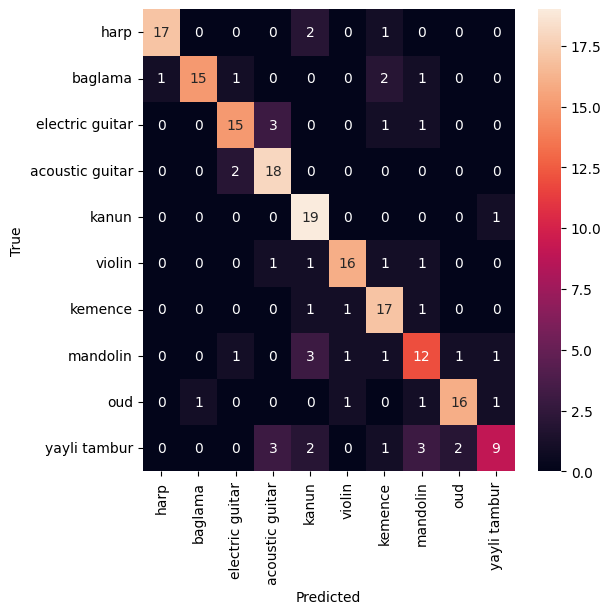

In [70]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Notes:
- Yayli tambur and mandolin are dragging down our accuracy
- Guitar types confused for each other - there are hybrid electric/acoustics in real life and in this dataset
- Better data would include guitar pictures with varied backgrounds and orientations
- The only confusing misclassification (in terms of subjective visual similarity is mandolin:kanun)

In [80]:
# return to our image viewing function

#function to print a random x images/labels for a given instrument
def check_instrument(instrument, sample_size):    
    check = df_clone.loc[df_clone.desc == instrument].sample(sample_size).reset_index(names = 'image_num')
    for row in range(sample_size):
        image = check.image[row]
        img = PIL.Image.open(image).convert('RGB')
        img = img.resize((max(1, int(img.size[0] * 200 / img.size[1])), 200))
        print('image ', check.image_num[row],':', check.desc[row])
        img.show()

image  442 : kanun


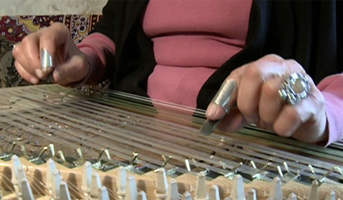

image  423 : kanun


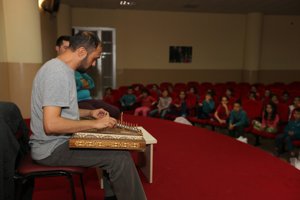

image  482 : kanun


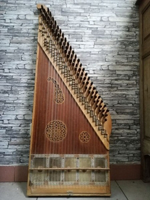

image  458 : kanun


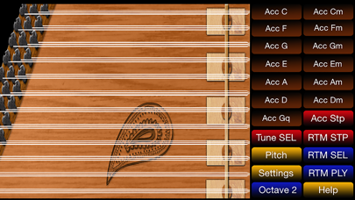

image  406 : kanun


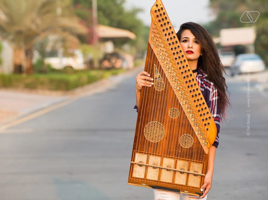

image  794 : mandolin


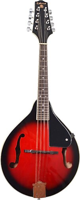

image  708 : mandolin


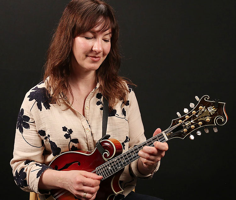

image  702 : mandolin


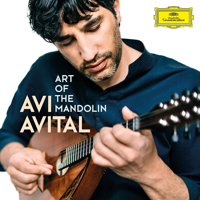

image  796 : mandolin


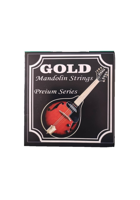

image  748 : mandolin


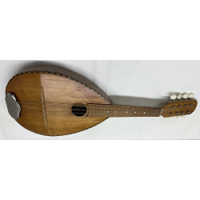

image  765 : mandolin


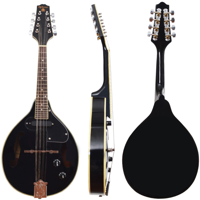

image  733 : mandolin


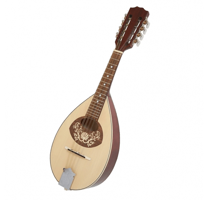

image  769 : mandolin


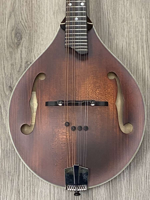

image  780 : mandolin


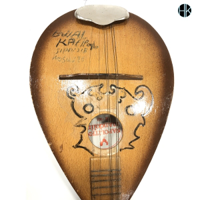

image  784 : mandolin


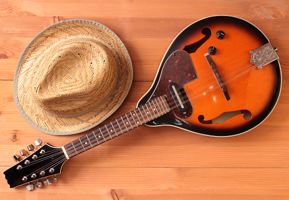

In [89]:
# why are mandolins being classified as kanun?
check_instrument('kanun', 5)
check_instrument('mandolin', 10)

image  257 : electric guitar


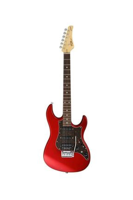

image  265 : electric guitar


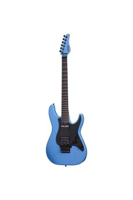

image  259 : electric guitar


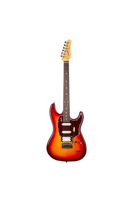

image  225 : electric guitar


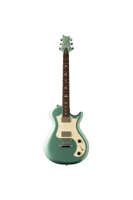

image  284 : electric guitar


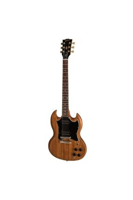

image  313 : acoustic guitar


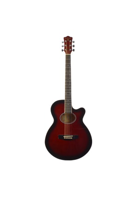

image  381 : acoustic guitar


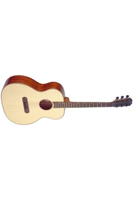

image  310 : acoustic guitar


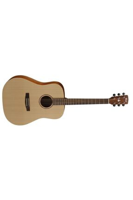

image  393 : acoustic guitar


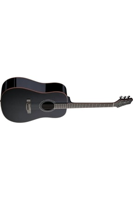

image  317 : acoustic guitar


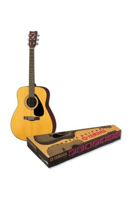

In [88]:
# too many guitars floating in space!
check_instrument('electric guitar', 5)
check_instrument('acoustic guitar', 5)

### Testing the Fine Tuned Model on Unfamiliar Images